## Step 1: Loading the data

We will start loading a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file containing 20 hours of heartbeats.

From the multiple libraries that can be used to read data from a CSV file ([pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html), …), we have chosen to use [cuDF](https://docs.rapids.ai/api/cudf/stable/10min.html), a Python GPU-accelerated DataFrame library part of [RAPIDS](https://rapids.ai/) framework.

For a general overview over zero-copy operations between frameworks, incl. small code examples, please visit this ["ML Frameworks Interoperability Cheat Sheet"](http://bl.ocks.org/miguelusque/raw/f44a8e729896a96d0a3e4b07b5176af4/).

This notebook and exercise is based on a 3-part blog series by Christian Hundt and Miguel Martinez from NVIDIA. You can revisit the material here:
  - [Machine Learning Frameworks Interoperability, Part 1: Memory Layouts and Memory Pools](https://developer.nvidia.com/blog/machine-learning-frameworks-interoperability-part-1-memory-layouts-and-memory-pools/)
  - [Machine Learning Frameworks Interoperability, Part 2: Data Loading and Data Transfer Bottlenecks](https://developer.nvidia.com/blog/machine-learning-frameworks-interoperability-part-2-data-loading-and-data-transfer-bottlenecks/)
  - [Machine Learning Frameworks Interoperability, Part 3: Zero-Copy in Action using an E2E Pipeline](https://developer.nvidia.com/blog/machine-learning-frameworks-interoperability-part-3-zero-copy-in-action-using-an-e2e-pipeline/)

In [1]:
!nvidia-smi

Tue Oct 11 14:34:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   78C    P0    35W /  N/A |   1826MiB / 16384MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import csv
import urllib
import zipfile
from scipy.io import loadmat

def download_data(root='./data/ECG', csvfile='heartbeats.csv', url=None):
        
        assert url != None, \
        "provide the URL to 22h of ECG data stated on the bottom of https://www.cs.ucr.edu/~eamonn/UCRsuite.html"
            
        filename = os.path.join(root, 'ECG_one_day.zip')
        csvfile = os.path.join(root, csvfile)
        
        if not os.path.isdir(root):
            os.makedirs(root)
        if not os.path.isfile(filename):
            urllib.request.urlretrieve(url, filename)
                    
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(root)    
    
        data = loadmat(os.path.join(root, 'ECG_one_day','ECG.mat'))['ECG'].flatten()
        
        with open(csvfile, 'w', encoding='UTF8') as f:            
            f.write('heartbeats\n')
            for date in data[:20000000]:
                f.write('%s\n' % date)
            

In [3]:
download_data(url='https://www.cs.ucr.edu/~eamonn/ECG_one_day.zip')

## Step 2: Parsing the CSV directly to GPU memory

We use RAPIDS cudf -- a CUDA-accelerated pandas drop-in replacement -- to directly parse the CSV to fast GPU memory

In [4]:
import time
import pandas as pd
t0 = time.time()
test = pd.read_csv("data/ECG/heartbeats.csv", dtype='float32')
print(f'Elapsed time: {time.time()-t0:.5f}')

Elapsed time: 1.64915


In [5]:
import cudf
t0 = time.time()
heartbeats_cudf = cudf.read_csv("data/ECG/heartbeats.csv", dtype='float32')
print(f'Elapsed time: {time.time()-t0:.5f}')
heartbeats_cudf

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Elapsed time: 2.62314


,heartbeats
0,-0.020
1,-0.010
2,-0.005
3,-0.005
4,-0.005
...,...
19999995,-0.005
19999996,0.015
19999997,0.005
19999998,-0.005


Let's plot an excerpt of the data

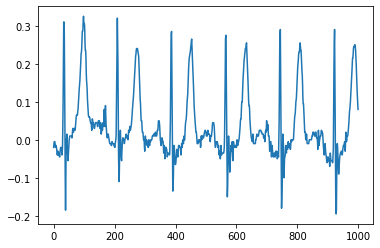

In [6]:
import pylab as pl

truncate = 1000
pl.plot(heartbeats_cudf.to_pandas()[:truncate])

## Step 3: QRS complex detection

Let's sample a Ricker wavelet which is proportional to the (negative) second derivative of a Gaussian

$g''(\tau) \propto - \frac{d^2}{d\tau^2} exp(-\frac{\tau^2}{2}) = exp(-\frac{\tau^2}{2}) (1-\tau^2)$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/MexicanHatMathematica.svg/2880px-MexicanHatMathematica.svg.png" alt="drawing" width="600"/>

Note that convolving a signal $f$ with the second derivative of a Gaussian $g$ is equivalent to smoothing $f$ with $g$ and then computing the second derivative, since

$(f \star g)' (t) = \frac{d}{dt} \int f(\tau) g(t-\tau) d \tau = \int f(\tau) \frac{d}{dt} g(t-\tau) d \tau = (f \star g')(t)$

and thus by induction:

$(f \star g)'' (t) = (f \star g'')(t)$

The standard deviation of the Gaussian governs the scale of the effect that we want to isolate. 

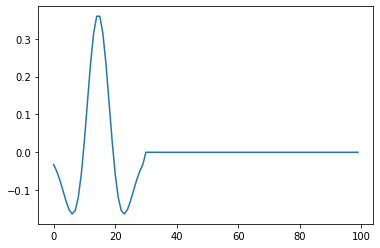

In [7]:
import cupy as cp

def get_ricker(window, length):
    
    time = cp.linspace(-3, +3, window)
    kernel = cp.zeros(length)
    
    # Using a ricker wavelet as bandpass filter (-) d^2/dt^2 exp(-0.5*t^2)    
    # https://www.wolframalpha.com/input/?i=d%5E2%2Fdt%5E2+exp%28-0.5*t%5E2%29
    # to isolate R in the QRS complex of each heartbeat
    kernel[:window] = cp.exp(-0.5 * time**2) * (1 - time**2)
    
    return 2*kernel/cp.sqrt(window)

wavelet = get_ricker(30, len(heartbeats_cudf))

# Let's inspect the zero-embedded Ricker wavelet
pl.plot(wavelet.get()[:100])
pl.show()

Subsequently, let us exploit the Fourier theorem to speed-up the convolution using the Fast Fourier Transform (FFT) in log-linear time.

$\mathcal F(f \star g) = \mathcal F(f) \odot \mathcal F(g) \Rightarrow f \star g = \mathcal F^{-1} \bigl(\mathcal F(f) \odot \mathcal F(g)\bigr)$

The (Hermitian) FFT is implemented in CuPy and accelerated by cuFFT under the hood. Conversion from cudf to CuPy is accomplished via DLPack:

In [8]:
def fftconv(signal, kernel):
    
    # compute 'signal o kernel', where 'o' is 1D convolution, by exploiting Fourier theorem:
    #    F(signal) * F(kernel) = F(signal o kernel)
    # this can be done in O(n log n) time where n is the length of the signal

    return cp.fft.irfft(cp.fft.rfft(signal)*cp.fft.rfft(kernel), n=len(signal))

/tmp/ipykernel_1405/3120687680.py:2: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  heartbeats_cupy = cp.fromDlpack(heartbeats_cudf['heartbeats'].to_dlpack())


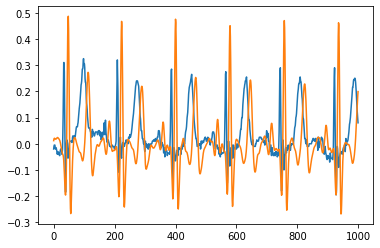

In [9]:
# convert heartbeats from cuDF to cupy
heartbeats_cupy = cp.fromDlpack(heartbeats_cudf['heartbeats'].to_dlpack())
    
# compute smoothed curvature via ricker wavelet
curvature_cupy = fftconv(heartbeats_cupy, wavelet)

# plot both the signal as well as QRS response
pl.plot(heartbeats_cudf.to_pandas()[:truncate])
pl.plot(curvature_cupy.get()[:truncate])
pl.show()

## Step 4: 1D Non-maximum suppression for robust local maxima detection

Our goal is now to detect the local maxima in the curvature graph above to partition the stream into individual heartbeats. To achieve that we implement a basic CUDA kernel using the jit-compiler [Numba](http://numba.pydata.org/). The kernel determines for each value in the curvature signal if it is the maximum in a predefined window. In the following, we spawn a fixed number of CUDA threads being (re-)used to enumerate the whole range of positions in the stream. Note that the corresponding indexing scheme is called [grid-stride loop](https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/). Each of the CUDA threads sequentially performs a max-reduction to determine the maximum. Although Numba comes with its own data types for device arrays, we can seamlessly pass CuPy arrays to Numba kernels without explicit type conversion. Both Numba and CuPy support the [CUDA array interface](https://numba.readthedocs.io/en/stable/cuda/cuda_array_interface.html) which allows for efficient zero-copy functionality across frameworks. 

In [10]:
from numba import cuda
import math

@cuda.jit
def segment_kernel(signal, window, out):
    
    base, step = cuda.grid(1), cuda.gridsize(1)    
    for position in range(base, signal.shape[0] - window + 1, step):        
        accum = -math.inf
        for index in range(window):            
            value = signal[position + index]
            accum = value if value > accum else accum
    
        #                 am I the maximum in my neighborhood?
        out[position] = 1 if accum == signal[position + (window + 1)//2] else 0

def segment_numba(signal, window):
    
    out = cp.empty(signal.shape[0] - window + 1, dtype=cp.int64)
    segment_kernel[80*32, 64](signal, window, out)    
    cuda.synchronize()
    
    # fixes sequences of the following for 0000011000-> 0000010000
    out[1:] *= (cp.diff(out) == 1)
    
    return out

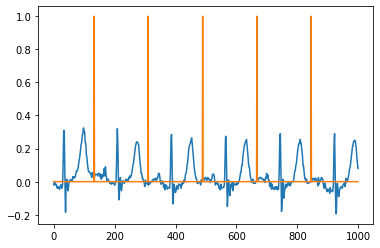

In [11]:
# let's segment the signal at the maximum peaks of the curvature graph
gate_cupy = segment_numba(curvature_cupy, window=180)

# let's plot the gates segmenting the stream
pl.plot(heartbeats_cudf.to_pandas()[:truncate])
pl.plot(gate_cupy.get()[:truncate])
pl.show()

## Step 5: Inspecting heart beat lengths

The binary mask gate_cupy is 1 for each position that starts a heartbeat and 0 otherwise. Subsequently, we want to transform this dense representation with many zeroes to a sparse one where one only stores the indices in the stream that start a heartbeat. You could write a CUDA-kernel using [warp-aggregated atomics](https://developer.nvidia.com/blog/cuda-pro-tip-optimized-filtering-warp-aggregated-atomics/) for that purpose. In CuPy, however, this can be achieved easier by filtering the index domain with the predicate gate==1. An adjacent difference (discrete derivative cupy.diff) computes the heartbeat lengths as index distance between positive gate positions. Finally, the computed lengths are visualized in a histogram.

In [12]:
def indices_and_lengths_cupy(gate):

    # all indices 0 1 2 3 4 5 6 ...
    iota = cp.arange(len(gate))

    # after filtering with gate==1 it becomes 3 6 10
    indices = iota[gate == 1]
    lengths = cp.diff(indices)
    
    return indices, lengths

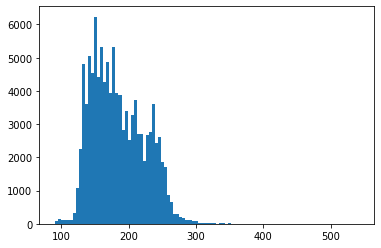

In [13]:
# inspect the segment lengths, we will later prune very long and short segments
indices_cupy, lengths_cupy = indices_and_lengths_cupy(gate_cupy)

# let's have a look at histogram of the heart beats lengths
pl.hist(lengths_cupy.get(), bins=100)
pl.show()

## Step 6: Candidate pruning and embedding in fixed length vectors

In a later stage we intend to train a Variational Autoencoder (VAE) with fixed-length input and thus the heartbeats must be embedded in a data matrix of fixed shape. According to the histogram the majority of length is somewhere in the range between 100 and 250. The embedding is accomplished with Numba kernel. A warp of 32 consecutive threads works on each heartbeat. The first thread in a warp (leader) checks if the heartbeat exhibits a valid length and increments a row counter in an atomic manner to determine the output row in the data matrix. Subsequently, the target row is communicated to the remaining 31 threads in the warp using the warp-intrinsic shfl_sync (broadcast). In a final step, we (re-)use the threads in the warp to write the values to the output row in the data matrix in a warp-cyclic fashion (warp-stride loop). Finally, we plot a few of the zero-embedded heartbeats and observe approximate alignment of the QRS complex -- exactly what we wanted to achieve.

In [14]:
@cuda.jit
def zero_padding_kernel(signal, indices, counter, lower, upper, out):
    """using warp intrinsics to speedup the calcuation"""
    
    for candidate in range(cuda.blockIdx.x, indices.shape[0]-1, cuda.gridDim.x):
        length = indices[candidate+1]-indices[candidate]
        
        # warp-centric: 32 threads process one signal
        if lower <= length <= upper:
            
            entry = 0
            if cuda.threadIdx.x == 0:
                # here we select in thread 0 what will be the target row
                entry = cuda.atomic.add(counter, 0, 1)
            
            # broadcast the target row to all other threads 
            # all 32 threads (warp) know the value
            entry = cuda.shfl_sync(0xFFFFFFFF, entry, 0)  
            
            for index in range(cuda.threadIdx.x, upper, 32):                
                out[entry, index] = signal[indices[candidate]+index] if index < length else 0.0
                
def zero_padding_numba(signal, indices, lengths, lower=100, upper=256):
    
    mask = (lower <= lengths) * (lengths <= upper)
    num_entries = int(cp.sum(mask))
    
    out = cp.empty((num_entries, upper), dtype=signal.dtype)
    counter = cp.zeros(1).astype(cp.int64)
    zero_padding_kernel[80*32, 32](signal, indices, counter, lower, upper, out)    
    cuda.synchronize()
    
    print("removed", 100-100*num_entries/len(lengths), "percent of the candidates")
    
    return out

removed 3.3824004429883274 percent of the candidates


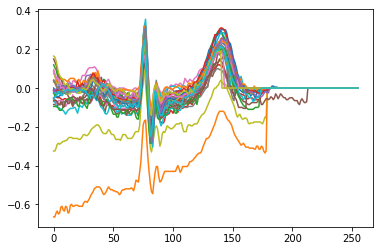

In [15]:
# let's prune the short and long segments (heartbeats) and normalize them
data_cupy = zero_padding_numba(heartbeats_cupy, indices_cupy, lengths_cupy, lower=100, upper=256)

# Let's have a look at a few extracted heartbeats
num_samples = 30
for sample in data_cupy[:num_samples]:
    pl.plot(sample.get())
pl.show()

## Step 7: Training a Variational Autoencoder (VAE)

In the last step, we train a Variational Autencoder (VAE) using Pytorch. We define the VAE network topology. Here, we use a convolutional version but you could also experiment with a classical [MLP VAE](https://github.com/pytorch/examples/blob/master/vae/main.py).

In [16]:
import torch

class Swish(torch.nn.Module):    

    def __init__(self):
        super().__init__()        
        self.alpha = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
    
    def forward(self, x):
        return x*torch.sigmoid(self.alpha.to(x.device)*x)

class Downsample1d(torch.nn.Module):    
    
    def __init__(self):
        super().__init__()
        
        self.filter = torch.tensor([1.0, 2.0, 1.0]).view(1, 1, 3)
    
    def forward(self, x):
        w = torch.cat([self.filter]*x.shape[1], dim=0).to(x.device)
        return torch.nn.functional.conv1d(x, w, stride=2, padding=1, groups=x.shape[1])

class LightVAE(torch.nn.Module):
    def __init__(self, num_dims):
        super(LightVAE, self).__init__()
        
        self.num_dims = num_dims
        assert num_dims & num_dims-1 == 0, "num_dims must be power of 2"
        
        self.down   = Downsample1d()
        self.up     = torch.nn.Upsample(scale_factor=2)
        self.sigma  = Swish()
        
        self.conv0  = torch.nn.Conv1d( 1,  4, kernel_size=3, stride=1, padding=1)
        self.conv1  = torch.nn.Conv1d( 4,  8, kernel_size=3, stride=1, padding=1)
        self.conv2  = torch.nn.Conv1d( 8, 16, kernel_size=3, stride=1, padding=1)
        self.convA  = torch.nn.Conv1d(16,  2, kernel_size=3, stride=1, padding=1)
        self.convB  = torch.nn.Conv1d(16,  2, kernel_size=3, stride=1, padding=1)

        self.restore = torch.nn.Linear(2, 16*num_dims//16)
        
        self.conv3  = torch.nn.Conv1d( 8, 4, kernel_size=3, stride=1, padding=1)
        self.conv4  = torch.nn.Conv1d( 4, 2, kernel_size=3, stride=1, padding=1)
        self.conv5  = torch.nn.Conv1d( 2, 1, kernel_size=3, stride=1, padding=1)
        
    def encode(self, x):
        
        x  = x.view(-1, 1, self.num_dims)
        x  = self.down(self.sigma(self.conv0(x)))
        x  = self.down(self.sigma(self.conv1(x)))
        x  = self.down(self.sigma(self.conv2(x)))
        
        return torch.mean(self.convA(x), dim=(2,)), \
               torch.mean(self.convB(x), dim=(2,))

    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def decode(self, z):
        
        x = self.restore(z).view(-1, 8, self.num_dims//8)
        x = self.sigma(self.conv3(self.up(x)))
        x = self.sigma(self.conv4(self.up(x)))   
              
        return self.conv5(self.up(x)).view(-1, self.num_dims)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = torch.sum(torch.mean(torch.square(recon_x-x), dim=1))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.1 * torch.sum(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return MSE + KLD

Pytorch expects its dedicated tensor type and thus we need to map the CuPy array data_cupy to a FloatTensor. We perform that again using zero-copy functionality via DLPack. The remaining code is plain Pytorch program that trains the VAE on the training set for 10 epochs using the Adam optimizer.

In [17]:
# zero-copy to pytorch tensors using dlpack
from torch.utils import dlpack

cp.random.seed(42)
cp.random.shuffle(data_cupy)

split = int(0.75*len(data_cupy))
trn_torch = dlpack.from_dlpack(data_cupy[:split].toDlpack())
tst_torch = dlpack.from_dlpack(data_cupy[split:].toDlpack())

dim = trn_torch.shape[1]
model = LightVAE(dim).to('cuda')
optimizer = torch.optim.Adam(model.parameters())

Let's train the VAE!

In [18]:
NUM_EPOCHS = 30
BATCH_SIZE = 1024

trn_loader = torch.utils.data.DataLoader(trn_torch, batch_size=BATCH_SIZE, shuffle=True)
tst_loader = torch.utils.data.DataLoader(tst_torch, batch_size=BATCH_SIZE, shuffle=False)

model.train()
for epoch in range(NUM_EPOCHS):
    trn_loss = 0.0
    for data in trn_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        trn_loss += loss.item()
        optimizer.step()
       
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, trn_loss / len(trn_loader.dataset)))

====> Epoch: 0 Average loss: 0.0434
====> Epoch: 1 Average loss: 0.0119
====> Epoch: 2 Average loss: 0.0089
====> Epoch: 3 Average loss: 0.0081
====> Epoch: 4 Average loss: 0.0077
====> Epoch: 5 Average loss: 0.0073
====> Epoch: 6 Average loss: 0.0071
====> Epoch: 7 Average loss: 0.0069
====> Epoch: 8 Average loss: 0.0068
====> Epoch: 9 Average loss: 0.0066
====> Epoch: 10 Average loss: 0.0065
====> Epoch: 11 Average loss: 0.0065
====> Epoch: 12 Average loss: 0.0064
====> Epoch: 13 Average loss: 0.0064
====> Epoch: 14 Average loss: 0.0063
====> Epoch: 15 Average loss: 0.0063
====> Epoch: 16 Average loss: 0.0063
====> Epoch: 17 Average loss: 0.0063
====> Epoch: 18 Average loss: 0.0063
====> Epoch: 19 Average loss: 0.0063
====> Epoch: 20 Average loss: 0.0063
====> Epoch: 21 Average loss: 0.0063
====> Epoch: 22 Average loss: 0.0063
====> Epoch: 23 Average loss: 0.0063
====> Epoch: 24 Average loss: 0.0063
====> Epoch: 25 Average loss: 0.0063
====> Epoch: 26 Average loss: 0.0063
====> Epoch

In [19]:
# it will be used to visualize a scatter char
mu_cudf = cudf.DataFrame()

model.eval()
with torch.no_grad():
    tst_loss = 0
    for data in tst_loader:
        recon_batch, mu, logvar = model(data)
        tst_loss += loss_function(recon_batch, data, mu, logvar).item()
        mu_cudf = mu_cudf.append(cudf.DataFrame(mu, columns=['x', 'y']))
            
tst_loss /= len(tst_loader.dataset)
print('====> Test set loss: {:.4f}'.format(tst_loss))

/opt/conda/lib/python3.8/site-packages/cudf/core/indexed_frame.py:2328: FutureWarning: The append method is deprecated and will be removed in a future version. Use cudf.concat instead.
  warnings.warn(


====> Test set loss: 0.0061


## Step 8: Visualizing the latent space and sampling heartbeats

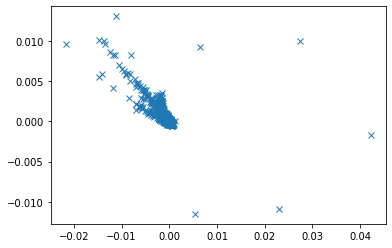

In [20]:
embedding = mu_cudf.to_pandas()
pl.plot(embedding['x'], embedding['y'], 'x')
pl.show()

 Sampling heartbeats from a Gaussian in latent space

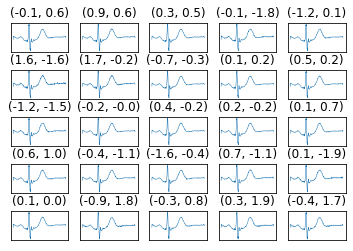

In [21]:
num_samples = 25
with torch.no_grad():
    latents = torch.empty(num_samples, 2).normal_(mean=0.0,std=1.0).to('cuda')
    samples = model.decode(latents).cpu()

for index, (sample, latent) in enumerate(zip(samples, latents)):
    pl.subplot(5, 5, index+1)
    pl.subplots_adjust(hspace=0.6)
    pl.title(str(tuple(latent.cpu().numpy().round(1))))
    pl.xticks([])
    pl.yticks([])
    pl.plot(sample, linewidth=0.5)

pl.savefig("fake_heartbeats.pdf", dpi=600)